<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

Импортируем библиотеки.

In [1]:
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# вставьте сюда параметры подключения предоставленные SkillFactory для работы с базой данных из Python 



In [3]:
# выполним подключение к базе данных SkillFactory
connection = psycopg2.connect(
    dbname=DBNAME,
    user=USER,
    host=HOST,
    password=PASSWORD,
    port=PORT
)

# 1. Знакомство с данными. #

Все необходимые таблицы находятся в схеме public базы данных project_sql (именно эту базу вам необходимо указать в параметре dbname при подключении):

<img src = img/SQL_pj2_2_1.png alt="drawing" style="width:400px;">

Познакомимся с каждой таблицей.

VACANCIES

Таблица хранит в себе данные по вакансиям и содержит следующие столбцы:

<img src = img/SQL_pj2_2_2.png alt="drawing" style="width:600px;">

Зарплатная вилка — это верхняя и нижняя граница оплаты труда в рублях (зарплаты в других валютах уже переведены в рубли). Соискателям она показывает, в каком диапазоне компания готова платить сотруднику на этой должности.

AREAS

Таблица-справочник, которая хранит код города и его название.

<img src = img/SQL_pj2_2_3.png alt="drawing" style="width:600px;">

EMPLOYERS

Таблица-справочник со списком работодателей.

<img src = img/SQL_pj2_2_4.png alt="drawing" style="width:600px;">


INDUSTRIES

Таблица-справочник вариантов сфер деятельности работодателей.

<img src = img/SQL_pj2_2_5.png alt="drawing" style="width:600px;">

EMPLOYERS_INDUSTRIES

Дополнительная таблица, которая существует для организации связи между работодателями и сферами их деятельности.

Эта таблица нужна нам, поскольку у одного работодателя может быть несколько сфер деятельности (или работодатели могут вовсе не указать их). Для удобства анализа необходимо хранить запись по каждой сфере каждого работодателя в отдельной строке таблицы.

<img src = img/SQL_pj2_2_6.png alt="drawing" style="width:600px;">



# 2. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [4]:
# Для SQL достаточно посчитать количество `id` в таблице вакансий с помощью count.

query_3_1 = f'''select count(id)
                from vacancies
             '''

In [5]:
# В качестве результата выведем полученное количество строк в виде ДФ.
# Уточнять уникальность (distinct) не понадобилось,
# т.к. само значение `id` вакансий предполагает уникальность каждой вакансии.

df3_1 = pd.read_sql_query(query_3_1, connection)
df3_1

,count
0,49197


##### Примечание. Второй способ:
Для ответа достаточно свывести всю таблицу вакансий и затем передать её в дата-фрейм (ДФ), где количество строк в ДФ и будет нащим ответом
Для `SQL` достаточно было посчитать количество `id` в таблице вакансий с помощью `count`:
```sql
select * 
from  from vacancies
```

2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [6]:
# Аналогично предыдущему запросу выводим таблицу работадателей:
query_3_2 = f'''select count(id)
                from employers
             '''

In [7]:
# В качестве результата запроса выведем ДФ c работадателями, где количество строк и столбцов будет указано.
df3_2 = pd.read_sql_query(query_3_2, connection)
df3_2

,count
0,23501


Из двух прежставленных таблиц  (**Вакансии** и **Работадатели**) можно сделать вывод, что вакансий более чем в два раза больше, чем работадателей, что вполне логично. Следjвательно, некоторые работадатели разместили более двух вакансий. 

3. Посчитате с помощью запроса количество регионов (таблица areas).

In [8]:
# Обрамся к таблице с регионами (areas) и  выведем таблицу в виде ДФ.
query3_3 = f'''select * --
               from areas
          
            '''
df3_3 = pd.read_sql_query(query3_3, connection)
df3_3

,id,name
0,2758,Тбилиси
1,8,Майкоп
2,1180,Нерюнгри
3,1240,Новокузнецк
4,2,Санкт-Петербург
...,...,...
1357,5043,Звёздный Городок
1358,3934,Воротынск\n
1359,4825,Чемал
1360,3708,Усть-Нера


Этот запрос можно как и предыдущие посчитать через count():
```sql
select 
    count(id)
from  from areas
```
Стоит отметить, что если посчитать количество уникальных регионов в таблице **Вакансий** или **Работодателей**, то их значения окажется меньше:
```sql
-- количество регионов в таблице с вакансиями
select 
    count(distinct area_id)
from vacancies
```
Ответ:769.

```sql
-- количество регионов в таблице с работодателями
select 
    count(distinct area)
from employers
```
Ответ:654.
 
 
Это говорит о том, что не все работадатели зарегистрированы в регионах с вакансиями и часто эти регионы могут не совпадать. Например,у работадателя есть головной офис (место его регистрации) и несколько дополнительных, которые не требуют регистрации как филиалы. А вакансия открывается как раз в допофисе.

4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [9]:
# Все делаем аналогично предыдущим запросам: выводим таблицу со сферами деятельности в виде ДФ,
# где будет отпражено число строк:
query_3_4 = f'''select *
               from industries
          
            '''
df3_4 = pd.read_sql_query(query_3_4, connection)
df3_4

,id,name
0,7.540,Разработка программного обеспечения
1,7.539,"Системная интеграция, автоматизации технологи..."
2,27.550,Безалкогольные напитки (производство)
3,27.551,"Безалкогольные напитки (продвижение, оптовая т..."
4,13.664,Управление и эксплуатация недвижимости
...,...,...
289,37.626,"Ассоциация в сфере культуры, искусства"
290,42.603,Табак (производство)
291,29.532,"Рыболовство, рыбоводство"
292,37.627,Благотворительная организация


Аналогично предыдущим запросам можно посчитать количество `id` в таблице `industries` с помошью `count`:
```sql
select
    count(id)
from industries
```
Ответ:294.

Поскольку справочник предполагает уникальность значений, то проверять уникальность с помощью `distinct` не нужно.

***

### Выводы по предварительному анализу данных:

Как уже отмечалось, количество вакансий в основной таблице в 2,093 раза превышает количество работодателей в справочнике. Если же мы посмотрим на количество уникальных работодателей в таблице с вакансиями, то их окажется всего 14906 , что в 3,3 раза меньше общего числа вакансий. Следовательно, некоторые работодатели предлагают как минимум 4 вакансии и более. И больше 36% общего числа работодателей в справочнике вообще не размещали вакансий в рассматриваемый период. 

Также количество регионов в справочнике превышает количество регионов в таблице с вакансиями почти в 2 (1,77) раза. Кроме того, количество регионов, где зарегистрированы работодатели, меньше регионов в таблице с вакансиями. Это говорит о том, что место регистрации работодателя не всегда совпадает с местом региона вакансии. Также некоторые работодатели размещают вакансии в разных регионах, отличных от места регистрации.

Касательно сфер деятельности, их значительно меньше количества компаний, что вполне логично. Скорее всего некоторые компании имеют несколько разных видов деятельности, но это нужно проверять отдельными запросами.



# 3. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [10]:
# Для выполнения задачи нам потребуется соединить таблицу вакансий с таблицей регионов и вывести нужные поля:
query_4_1 = f'''select 
                  a.name area,
                  count(a.name) cnt
               from vacancies v
                   join areas a on a.id = v.area_id  
               group by area     -- требуется группировка по регионам для подсчета количества строк в каждом регионе
               order by cnt desc -- сортируем по убыванию
               limit 20          -- ограничим вывод первых двадцати регионов с помощью limit
            '''

In [11]:
df4_1 = pd.read_sql_query(query_4_1, connection)
df4_1

,area,cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892
5,Екатеринбург,1698
6,Нижний Новгород,1670
7,Казань,1415
8,Краснодар,1301
9,Самара,1144


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [12]:
# Достаточно поставить условие по двум полям salary_from и salary_to, все необходимые данные есть в таблице вакансий.
query_4_2 = f'''select 
                    count(v.id) 
                from vacancies v
                where salary_from is not null or salary_to is not null
            '''

In [13]:

df4_2 = pd.read_sql_query(query_4_2, connection)
df4_2

,count
0,24073


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [14]:
# достаточно поставить условие по двум полям salary_from и salary_to, в соединении таблиц необходимости нет.
query_4_3 = f'''select 
                    round(avg(salary_from)) agv_from, -- считаем среднее значение всех начальных зарплат
                    round(avg(salary_to)) agv_to      -- считаем среднее значение всех конечных зарплат
                from vacancies
            '''


In [15]:
# результат запроса
df4_3 = pd.read_sql_query(query_4_3, connection)
df4_3

,agv_from,agv_to
0,71065.0,110537.0


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [16]:
# Для решения потребуется толькотабоица вакансий:
query_4_4 = f'''select 
                    lower(schedule||'__'||employment) schedule_employment,
                    
                    /*для улучшения читаемости таблицы выведем все значения в нижнем регистре, использовав lower,
                    и объединим поля с грфиком и типом трудоустройства с помощью ||, добавив нижнее подчеркивание '__'*/
                    
                    count(lower(schedule||'__'||employment)) cnt -- столбей с количеством вакансий выведем для наглядности
                from vacancies
                group by schedule_employment
                order by cnt desc
            '''

In [17]:
# текст запроса
df4_4 = pd.read_sql_query(query_4_4, connection)
df4_4

,schedule_employment,cnt
0,полный день__полная занятость,35367
1,удаленная работа__полная занятость,7802
2,гибкий график__полная занятость,1593
3,удаленная работа__частичная занятость,1312
4,сменный график__полная занятость,940
5,полный день__стажировка,569
6,вахтовый метод__полная занятость,367
7,полный день__частичная занятость,347
8,гибкий график__частичная занятость,312
9,полный день__проектная работа,141


5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [18]:
# используем только таблицу с вакансиями, выведем сгрупированный столбец с опытом работы в порядке убывания кол-ва строк.
query_4_5 = f'''select
                    experience
                -- если добавить count(id) в таблицу можно сделать более конкретные выводы
                from vacancies
                group by experience
                order by count(id) desc
            '''

In [19]:
df4_5 = pd.read_sql_query(query_4_5, connection)
df4_5

,experience
0,От 1 года до 3 лет
1,От 3 до 6 лет
2,Нет опыта
3,Более 6 лет


***

### Выводы по детальному анализу вакансий:

К первой пятёрке городов относится почти 29% (14194) всех размещенных вакансий, что вполне логично. Если посмотреть на первую двадцатку регионов, то к ним относятся больше 60% всех представленных вакансий (29787). Все города в 20-тке - крупные промышленные центры, где самая большая потребность в любых кадрах и не только IT-специалистах.

Около 50% всех вакансий имеют предложение по заработной плате (начальной или конечной). Крупные компании, как правило не стремятся размещать свои предложения с заработными платами. Как правило, они делают предложение по зарплате уже конкретному соискателю, прошедшему предварительный отбор по резюме.

Значительное большинство работодателей предлагают полную занятость и полный рабочий день (71,8% от всех вакансий), вакансии с удаленной работой и с полным рабочим днем 15,8%, что в сумме составляет около 88% от числа всех вакансий. Можно предположить, что работодателям, размещающим подобные вакансии, требуются сотрудники на долгую перспективу. Интересно сравнить на сколько по таким вакансиям отличается уровень предлагаемых заработных плат. Как правило, на удаленной работе оклады ниже, чем при работе в офисе компании.

В заключении нужно отметить, что большинству работодателей (больше 50% от всех вакансий) требуются специалисты с опытом работы от одного до трех лет. В плане предложений по заработным платам это одна из низкооплачиваемых групп (ниже только полное отсутствие опыта). Как правило, это самая мобильная группа среди специалистов. Они часто меняют работу в поисках лучшего места, а работодателю на такие вакансии возможно не требуются профессионалы, что позволяет компаниям экономить на фонде оплаты труда. Самая редкая категория-специалисты с опытом более 6 лет, что вполне логично, поскольку таких соискателей обычно меньшинство, как и должностей, требующих такой уровень подготовки.


# 4. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [20]:
#соеденив таблицы вакрнсий и работадателей, выведем первых пять работадателей по числу вакансий
query_5_1_1 = f'''select 
                    e.name name_employers
                from vacancies v
                    join employers e on v.employer_id=e.id
                group by name_employers
                order by count(v.id) desc
                limit 5
            '''


In [21]:
# результат запроса
df5_1_1 = pd.read_sql_query(query_5_1_1, connection)
df5_1_1

,name_employers
0,Яндекс
1,Ростелеком
2,Тинькофф
3,СБЕР
4,Газпром нефть


In [22]:
# второй вариант: с помощью объединения выведем первую и пятую позицию, как спрашивалось в запросе:
query_5_1_2 = f'''(select 
                       e.name name_employers
                   from vacancies v
                       join employers e on v.employer_id=e.id
                   group by name_employers
                   order by count(v.id) desc
                   limit 1)
                   union 
                  (select 
                       e.name name_employers               
                   from vacancies v
                       join employers e on v.employer_id=e.id
                   group by name_employers
                   order by count(v.id) desc
                   offset 4 limit 1 )
                   '''

In [23]:
# результат запроса
df5_1_2 = pd.read_sql_query(query_5_1_2, connection)
df5_1_2

,name_employers
0,Газпром нефть
1,Яндекс


Если вывести запрос с количеством вакансий, то увидим, Яндекс размещает в 4 раза больше вакансий по сравнению с остальными участниками  первой пятерки.
```sql
select 
    e.name name_employers,
    count(v.id) 
from vacancies v
join employers e on v.employer_id=e.id
group by name_employers
order by count(v.id) desc
limit 5
```

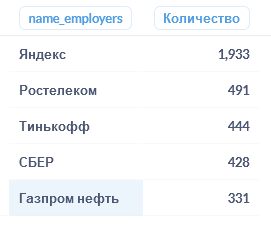

2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [24]:
query_5_2 = f'''select 
            /* Соединив таблицу с территориями с помощью left join с вакансиями и работадателями
            и посчитав количество работадателей и вакансий группированных по регионам получим требуемую таблицу.
            Добавив условие об отсутствии вакансий, получим регионы, где нет вакансий.
            Упорядочив нашу таблицу по убыванию, выведем первый регион*/
                      a.name area_name,
                      count(e.id) cnt_employers,
                      count(v.id) cnt_vacancies
                  from areas a
                      left join vacancies v on v.area_id=a.id
                      left join employers e on e.area=a.id
                  where v.id is null
                  group by area_name
                  order by cnt_employers desc
                  limit 1
            '''

In [25]:
# результат запроса
df5_2 = pd.read_sql_query(query_5_2, connection)
df5_2

,area_name,cnt_employers,cnt_vacancies
0,Россия,410,0


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [26]:
# Если нам не требуется знать название компани работадателя, то достаточно таблицы с вакансиями, где есть employer_id:
query_5_3 = f'''select 
                    employer_id,
                    count(distinct area_id) -- считаем количество уникальных регионов
                from vacancies
                group by employer_id
                order by 2 desc
                --limit 1
            '''

In [27]:
df5_3 = pd.read_sql_query(query_5_3, connection)
df5_3

,employer_id,count
0,1740,181
1,2748,152
2,5724811,116
3,5130287,88
4,3682876,71
...,...,...
14901,810278,1
14902,810313,1
14903,810551,1
14904,810688,1


In [28]:
# чтобы узнать наименования компаний, соединим таблицу вакансий с таблицей работадатедей,
# остальное аналогично запросу_5_3
query_5_3_2 = f'''select 
                    e.name,
                count(distinct v.area_id)
                from vacancies v
                    join employers e on e.id=v.employer_id
                group by v.employer_id,e.name
                order by 2 desc
                --limit 1
            '''
df5_3_2 = pd.read_sql_query(query_5_3_2, connection)
df5_3_2

,name,count
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71
...,...,...
14901,НПП Авиатрон,1
14902,Центр дистанционных торгов,1
14903,Городские Телекоммуникационные Системы,1
14904,"Введенский, Отель",1


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [29]:
# необходимо соединить с помощью left join таблицы работадателей и дополнительной таблицей (работадаьели_сфера деятельности)
# с уловием об отсутствии сфер деятельности: 
query_5_4 = f'''select 
                    count(e.id)
                from employers e left join employers_industries ei on ei.employer_id=e.id 
                where ei.industry_id is null
            '''
df5_4 = pd.read_sql_query(query_5_4, connection)
df5_4

,count
0,8419


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [30]:
# соединение аналогичное предыдущему, поскольну нам не нужны наименования сфер деятельности, а только их количество:
query_5_5 = f'''select 
                    e.name
                from employers e left join employers_industries ei on ei.employer_id=e.id 
                group by 1
                having count (distinct ei.industry_id)=4 -- условие по количеству видов деятельности
                order by 1
                offset 2 limit 1                         -- ограниченине по выводу
            '''
df5_5 = pd.read_sql_query(query_5_5, connection)
df5_5


,name
0,2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [31]:
# требуется тройное соединение,т.к. нужно конкретное название сферы деятельности:

query_5_6 = f'''select 
                    count(distinct e.id)
                from employers e left join employers_industries ei on ei.employer_id=e.id 
                    left join industries i on ei.industry_id=i.id 
                where i.name in ('Разработка программного обеспечения')
                -- where i.name like '%Разработка программного обеспечения%' -другой вариант вывода условия через like
            '''
df5_6 = pd.read_sql_query(query_5_6, connection)
df5_6


,count
0,3553


7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [32]:
# код для получения списка городов-милионников:
# Т.к. город Воронеж в таблице в Википедии представлен с окончанием [а], требуется убрать лишнее окончание.
# В дальнейм полученный список город выводим в виде кортежа.
url = 'https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8' 
df_html = pd.read_html(url) 
df_cities = df_html[1] 
df_cities['Город']=df_cities['Город'].apply(lambda x: x.replace('[a]',''))
cities = df_cities['Город'].to_list()
cit=tuple(cities)
cit

('Москва',
 'Санкт-Петербург',
 'Новосибирск',
 'Екатеринбург',
 'Казань',
 'Нижний Новгород',
 'Челябинск',
 'Красноярск',
 'Самара',
 'Уфа',
 'Ростов-на-Дону',
 'Омск',
 'Краснодар',
 'Воронеж',
 'Пермь',
 'Волгоград')

In [33]:
# потребуется соединить вакансии с работадателями и регионами и довавить условие по наименованию компании
# и городам миллионникам, указанным в кортеже cit

query_5_7 = f'''select 
                    a.name city,
                    count(v.id) cnt               -- считаем вакансии по городам
                from vacancies v join employers e on v.employer_id=e.id
                                 join areas a on v.area_id=a.id 
                where e.name = 'Яндекс' and a.name in {cit} 
                group by 1                                 -- для упрощения используем позиционную группировку

                union all                                  -- объединяем таблицы по строкам
                
                select
                    'Total', count(v.id)
                from vacancies v join employers e on v.employer_id=e.id
                                join areas a on v.area_id=a.id 
                where e.name in ('Яндекс') 
                and a.name in {cit} 
                
                order by 2
            '''


In [34]:
# результат запроса
df5_7 = pd.read_sql_query(query_5_7, connection)
df5_7

,city,cnt
0,Омск,21
1,Челябинск,22
2,Красноярск,23
3,Волгоград,24
4,Пермь,25
5,Казань,25
6,Ростов-на-Дону,25
7,Уфа,26
8,Самара,26
9,Краснодар,30


***

### Выводы по анализу работодателей:

По имеющимся запросам можно сделать вывод о том, что самые большие компании, такие как Яндекс, Ростелеком, Сбер, выкладывают наибольшее количество предложений для соискателей. Безусловный лидер по количеству регионов размещения вакансий-это Яндекс, он же является и лидером по общему количеству вакансий в исследуемых данных (4% от числа всех вакансий).

Около трети всех работодателей из справочника не указали сферы деятельности (8419), возможно именно эти работодатели не размещали и вакансий, поскольку порядка 36% работодателей из справочника не предлагали вакансий в рассматриваемый период.

Только 15% от общего числа работодателей из справочника занимаются разработкой программного обеспечения. Если сделать аналогичный запрос учитывая только работодателей, размещавших вакансии, то их количество сократиться до 2592, но увеличится в процентом отношении до 17%. Мы не рассматриваем другие сферы деятельнольности, т.к. в отрыве от информации по вакансиям значение данной информации не является решающим.



# 5. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [35]:
# c помощью lower и like ищем все требуемые сочетания в наименованиях вакансий и считаем количество полученных строк:
query_6_1 = f'''select
                    count(id)
                from vacancies
                where lower(name) like '%data%' or lower(name) like '%данн%'

'''

In [36]:
# результат запроса
df6_1 = pd.read_sql_query(query_6_1, connection)
df6_1

,count
0,1771


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [37]:
# Все аналогично предыдущему запросу, только условий немного побольше.
# Условия по дата-саентисту записываем через оператор ИЛИ(OR),выделяя их скобками,
# затем добавляем условие по Junior через оператор  И(AND)

query_6_2 = f'''select 
                    count(id)
                from vacancies 
                where (lower(name) like '%data scientist%'
                       or lower(name) like '%data science%'
                       or lower(name) like '%исследователь данных%'
                       or lower(name) like '%machine learning%'
                       or (name like '%ML%' and name not like '%HTML%')
                       or lower(name) like '%машинн%обучен%')
                       and (lower(name) like '%junior%' or employment='Стажировка' or experience='Нет опыта')
            '''

In [38]:
# результат запроса

df6_2 = pd.read_sql_query(query_6_2, connection)
df6_2

,count
0,51


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [39]:
# все аналогично предыдущим запросам просто меняем последнее условие:
query_6_3 = f'''select
                    count(distinct id)
                from vacancies 
                where (lower(name) like '%data scientist%'
                       or lower(name) like '%data science%'
                       or lower(name) like '%исследователь данных%'
                       or lower(name) like '%machine learning%'
                       or (name like '%ML%' and name not like '%HTML%')
                       or lower(name) like '%машинн%обучен%')
                       and (key_skills like '%SQL%' or key_skills like '%postgres%')
            '''

In [40]:
# результат запроса
df6_3 = pd.read_sql_query(query_6_3, connection)
df6_3

,count
0,201


In [41]:
# Дополнительно посчитаем общее количество вакансий по DS без добавочных условий:
query_DS = f'''select
                    count(distinct id)
                from vacancies 
                where (lower(name) like '%data scientist%'
                       or lower(name) like '%data science%'
                       or lower(name) like '%исследователь данных%'
                       or lower(name) like '%machine learning%'
                       or (name like '%ML%' and name not like '%HTML%')
                       or lower(name) like '%машинн%обучен%')
                       
            '''

df_DS = pd.read_sql_query(query_DS, connection)
df_DS

,count
0,480


4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [42]:
# меняем последнее условие согласно запросу, остальное все аналогично предыдущим запросам:
query_6_4 = f'''select
                    count(distinct id)
                from vacancies 
                where (lower(name) like '%data scientist%'
                   or lower(name) like '%data science%'
                   or lower(name) like '%исследователь данных%'
                   or lower(name) like '%machine learning%'
                   or (name like '%ML%' and name not like '%HTML%')
                   or lower(name) like '%машинн%обучен%')
                   and (key_skills like '%Python%')
            '''

In [43]:
df6_4 = pd.read_sql_query(query_6_4, connection)
df6_4

,count
0,351


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [44]:
#  как и предудущих запросам нам потребуется только таблица вакансий:
query_6_5 = f'''select
                /*Расчитывая среднее количество навыков для DS, необходимо прибавить единицу,
                поскольку мы считаем промежутки между указанными навыками, а их всегда на единицу меньше */
                    round(avg((length(key_skills) - length(replace(key_skills, CHR(9), '')))+1), 2)
                from vacancies 
                where (lower(name) like '%data scientist%'
                   or lower(name) like '%data science%'
                   or lower(name) like '%исследователь данных%'
                   or lower(name) like '%machine learning%'
                   or (name like '%ML%' and name not like '%HTML%')
                   or lower(name) like '%машинн%обучен%')
                   and (key_skills is not null)
            '''

In [45]:
df6_5 = pd.read_sql_query(query_6_5, connection)
df6_5

,round
0,6.41


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [46]:
# с помощью coalesce() меняем NULL на значение  заполненного столбца, чтобы в каждом столце получить ненулневое значение:
query_6_6 = f'''select
                    experience,
                    round(avg((coalesce(salary_from, salary_to)+coalesce(salary_to, salary_from))/2))

                from vacancies 
                where (lower(name) like '%data scientist%'
                   or lower(name) like '%data science%'
                   or lower(name) like '%исследователь данных%'
                   or lower(name) like '%machine learning%'
                   or (name like '%ML%' and name not like '%HTML%')
                   or lower(name) like '%машинн%обучен%')
                and (salary_from is not null or salary_to is not null)
                group by 1     -- позиционная группировка по первому столбцу
            '''

In [47]:
# результат запроса
df6_6 = pd.read_sql_query(query_6_6, connection)
df6_6

,experience,round
0,Нет опыта,74643.0
1,От 1 года до 3 лет,139675.0
2,От 3 до 6 лет,243115.0


***

### Выводы по предметному анализу:

В этом разделе мы исследовали вакансии связанные с DS. Самих вакансий, связанных с данными, в представленных таблицах не так много-около 3,6% от общего числа всех вакансий. Для джуниоров без опыта работы или ищущих стажировку ситуация выглядит еще менее перспективно - только 51 вакансия. Вакансий для DS без доп условий всего 480 (27% от вакансий, связанных с данными). Соискатели на DS должны иметь в среднем больше шести навыков, причем знание Python требуют 71% от числа вакансий DS и 42%- SQL соответственно. Написание кода на Python является одним из ключевых навыков для DS.

Усредненная заработная плата новичков более чем в три раза меньше, чем у специалистов с опытом работы от 3 лет. Дата-сайентисты с небольшим опытом работы могут рассчитывать в среднем на 140 тыс. руб., что почти в два раза меньше, чем у соискателей с опытом от 3-х лет, что является неплохим стимулом для продвижения в профессии.

Таким образом, специализация DS не такая востребованная, как ожидалось, требующая при этом достаточно много навыков от соискателей. Найти работу новичкам очень сложно из-за малого количества предложений. Но сравнительно малый период для повышения дохода почти в три раза делают это направление привлекательным для будущих соискателей.


# Общий вывод по проекту

### Дополнительное исследование.
Прежде чем перейти к общим выводам по проекту, проанализируем еще некоторые взаимосвязи, которые ранее нами не были рассмтрены.

Чтобы далеко не уходить от нашей основной таблицы вакансий, посмотрим на самые популярные вакансии в IT в предоставленных данных. Направление DS не так популярно, т.к.ранее нами было выявлено всего 480 вакансий. Отбор будем с учетом возможных повторений при этом выберем первые пять и добавим к ним для сравнения наши отобраные вакансии для DS.

In [48]:
query_7_1 = f'''(select
                   name,
                   count(id) cnt
              from vacancies 
              group by 1
              order by  cnt desc
              limit 5)
              
              union all
              
              (select
                    'Вакансиии для DS',
                    count(distinct id)
                from vacancies 
                where (lower(name) like '%data scientist%'
                       or lower(name) like '%data science%'
                       or lower(name) like '%исследователь данных%'
                       or lower(name) like '%machine learning%'
                       or (name like '%ML%' and name not like '%HTML%')
                       or lower(name) like '%машинн%обучен%'))
            '''
df_7_1 = pd.read_sql_query(query_7_1, connection)
df_7_1

,name,cnt
0,Системный администратор,1761
1,Программист 1С,1153
2,Бизнес-аналитик,488
3,Специалист технической поддержки,457
4,Системный аналитик,432
5,Вакансиии для DS,480


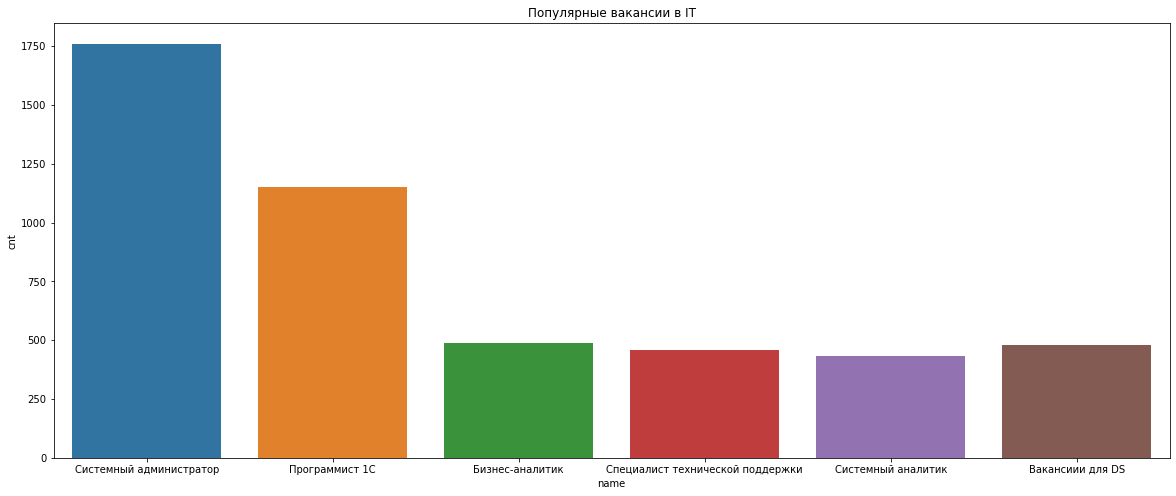

In [50]:
# Для наглядности построим столбчатую диаграмму для выбранных вакансий:
fig = plt.figure(figsize=(20, 8))
barplot = sns.barplot(
    data=df_7_1,
    x='name',
    y='cnt',

)
barplot.set_title('Популярные вакансии в IT');

Из общего списка лидер по вакансиям - *системный администратор*, число вакансий в 4 раза больше пятой вакансии в списке (*системный аналитик*) и в 3,5 раза больше всех вакансий для DS. Пользуются спросом *програмисты 1С*-второе место. 
Данные весьма приближенные, т.к. мы не делали укрупнения по направлениям профессий как для DS, возможно втречаются повторения, как с программистами 1С (если смотреть первые 10 позиций, то программсты 1С появятся еще на 8 месте), но в любом случае можно сделать вывод, что направление DS не самое популярное в сфере IT, хотя и достаточно высоко оплачиваемо.

Теперь посмотрим на средние заработные платы для первых пяти популярных вакансий, для которых эти заработные платы объявлены:

In [51]:
query_7_2 = f'''select
                  v.name,
                  round(avg((coalesce(v.salary_from, v.salary_to)+coalesce(v.salary_to, v.salary_from))/2)) average_salary,
                  count(v.id) cnt
                from vacancies v join areas a on v.area_id=a.id
                where (salary_from  is not null or salary_to is not null) 
                group by v.name
                order by cnt desc
                limit 5'''

df_7_2 = pd.read_sql_query(query_7_2, connection)
df_7_2

,name,average_salary,cnt
0,Системный администратор,50115.0,1287
1,Программист 1С,110189.0,729
2,Специалист технической поддержки,43211.0,335
3,Инженер-программист,50478.0,279
4,Программист 1C,96906.0,228


И посмотрим на уровень средних зарплат для пяти популярных вакансий в городах миллионниках:

In [52]:
query_7_3 = f'''select
                  v.name,
                  round(avg((coalesce(v.salary_from, v.salary_to)+coalesce(v.salary_to, v.salary_from))/2)) average_salary,
                  count(v.id) cnt
                from vacancies v join areas a on v.area_id=a.id
                where (salary_from  is not null or salary_to is not null)
                      and a.name in {cit}
                group by v.name
                order by cnt desc
                limit 5'''
df_7_3 = pd.read_sql_query(query_7_3, connection)
df_7_3

,name,average_salary,cnt
0,Системный администратор,55279.0,443
1,Программист 1С,117681.0,289
2,Специалист технической поддержки,47474.0,156
3,Бизнес-аналитик,106504.0,101
4,Аналитик,74970.0,97


In [53]:
# для Москвы пятерка популярных вакансий выглятит так:
query_7_4 = f'''select
                  v.name,
                  round(avg((coalesce(v.salary_from, v.salary_to)+coalesce(v.salary_to, v.salary_from))/2)) average_salary,
                  count(v.id) cnt
                from vacancies v join areas a on v.area_id=a.id
                where (salary_from  is not null or salary_to is not null)
                      and a.name in ('Москва')
                group by v.name
                order by cnt desc
                limit 5'''
df_7_4 = pd.read_sql_query(query_7_4, connection)
df_7_4

,name,average_salary,cnt
0,Бизнес-аналитик,135827.0,40
1,Системный администратор,97618.0,38
2,Аналитик,101973.0,23
3,Специалист технической поддержки,76993.0,21
4,Системный аналитик,201281.0,16


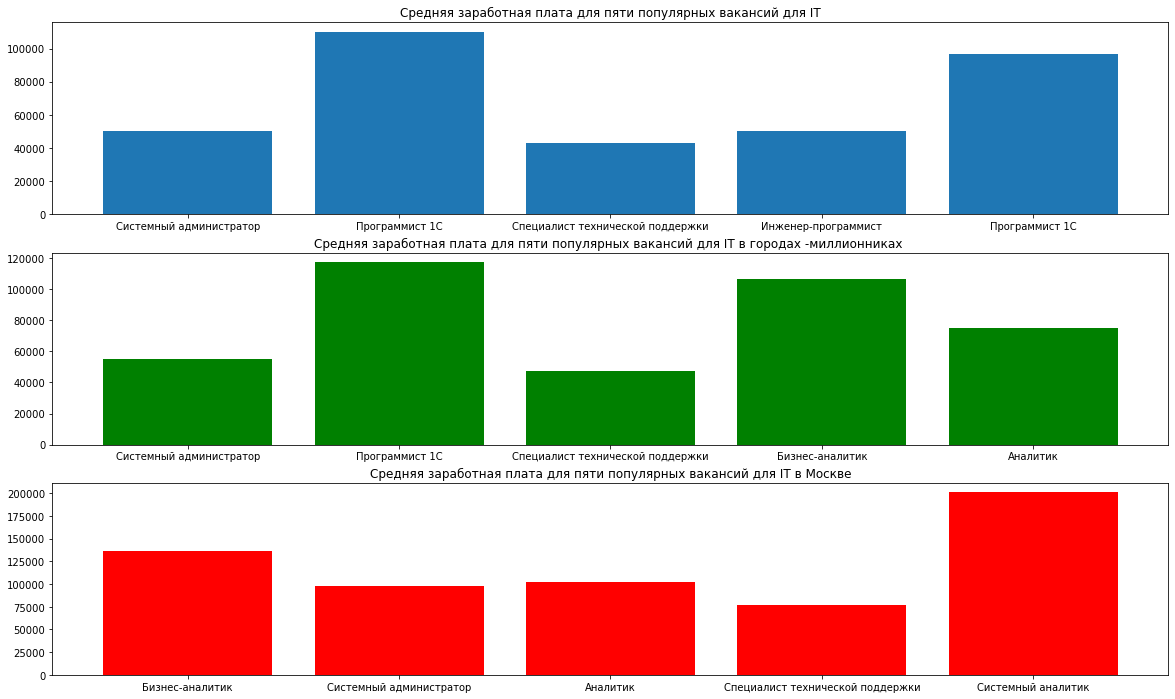

In [54]:
# построим диаграммы лдля наших таблиц:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 12))

axes[0].bar(x=df_7_2.name, 
            height=df_7_2.average_salary,
            label='Заработная плата')
axes[0].set_title('Средняя заработная плата для пяти популярных вакансий для IT')
axes[0].xaxis.set_tick_params(rotation=0)


axes[1].bar(x=df_7_3.name, 
            height=df_7_3.average_salary,
            label='Заработная плата', color='green')
axes[1].set_title('Средняя заработная плата для пяти популярных вакансий для IT в городах -миллионниках ')
axes[1].xaxis.set_tick_params(rotation=0)

axes[2].bar(x=df_7_4.name, 
            height=df_7_4.average_salary,
            label='Заработная плата', color='red')
axes[2].set_title('Средняя заработная плата для пяти популярных вакансий для IT в Москве')
axes[2].xaxis.set_tick_params(rotation=0)

В первой диаграмме нам встретился дважды программист 1С, причем надо отметить, что уровень зарплаты для них достаточно высок по сравнению с остальными (почти в 2 раза выше, по сравнению с остальными вакансиями). Это говорит о востребованности данного направления или изначально язык 1С не слишком популярен, из-за чего специалистов на рынке не так много.

Если сравнивать пятерку популярных вакансий в городах-миллиониках с общей таблицей, то первые три популярные вакансии совпадают, причем зарплаты примерно на том же уровне и самый высокооплачиваемый- это программист 1С.Само количество вакансий отличается: в первой таблице почти в 2,5 раза больше по всем пяти позициям, чем во второй.

По Москве пятерка популярных вакансий с озвученными зарплатами отличается от двух предыдущих таблиц. Во-первых, количество вакансий на порядок меньше, причем если смотреть количество популярных вакансий в столице для первой позиции (*бизнес-аналитик*) без условий по зарплате их количество увеличится до 173 (больше в 4 раза). 
Во-вторых, уровень заработных плат в Москве выше, чем в других регионах. Например, специалист технической поддержки (4 место)  или системный администратор (2 место) могут рассчитывать на доход почти в 2 раза превышающий в среднем по регионам. 
Самые востребованные и высокооплачиваемые специалисты- это  *бизнес-аналитики*, по зарплате их опережают только *системные аналитики* (средний уровень предлагаемого дохода от 200 тыс. руб.), но количество вакансий не велико по сравнению с первой позицией.

Все выше перечисленное говорит о привлекательности Москвы как места работы для IT-специалиста, особенно если его профессиональный уровень достаточно высок.

Это небольшое исследование показывает, как много информации еще не проанализировано. Можно исследовать какие навыки требуются самым высокооплачиваемым и востребованным профессиям или проанализировать работодателей по видам вакансий в разных регионах, например, по Яндексу или Ростелекому. Но для начала следует укрупнить вакансии по направлениям, чтобы не встречались повторения, как с программистами 1С.

### Подведем итог исследования, обобщите выводы по исследованию:

Общее количество вакансий в сфере IT достаточно велико, почти 50 тыс. представлено для исследования.

Только 64% из общего числа работодателей разместили свои объявления в исследуемых данных.

Есть крупные работодатели, которые размещают по несколько вакансий более, чем в 100 разных регионах (безусловный лидер - Яндекс). 

Самые популярные места для работы -столичные города: Москва и Санкт-Петербург.

Значительное большинство работодателей предлагают полную занятость и полный рабочий день. Большинству работодателей (больше 50% от всех вакансий) требуются специалисты с опытом работы от одного до трех лет.  

Только в половине представленных вакансий встречаются предложения по заработной плате, причем чем выше должность , тем меньше информации.

Направление DS - не самое популярное, но достаточно высокооплачиваемое, даже для специалистов с минимальным опытом работы. Одними из ключевых навыков для специалиста в DS является знание языка `Python` и `SQL`.
